In [1]:
import tensorflow as tf
import kagglehub
import shutil
import os
from google.colab import drive
from tensorflow.keras.models import Sequential, load_model

#get latest version of dataset
path = kagglehub.dataset_download("seanscully29/flowers-classification")
print("Path to dataset files:",path)

100%|██████████| 62.1M/62.1M [00:00<00:00, 158MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/seanscully29/flowers-classification/versions/1


In [2]:
local_path="./flower_species_dataset"
os.makedirs(local_path, exist_ok=True)

try:
  for item in os.listdir(path):
    s = os.path.join(path,item)
    d = os.path.join(local_path,item)
    if os.path.isdir(s):
      shutil.copytree(s,d)
    else:
      shutil.copy2(s,d)
except FileExistsError: #If code accidentally runs again, print text signaling that the path already exists instead of throwing an error
  print(f"{local_path} already exists.")

print(f"Dataset saved at: {local_path}")

Dataset saved at: ./flower_species_dataset


In [3]:
source_path="/content/flower_species_dataset/flowerdataset"
training_path='./flower_species_dataset/training'
testing_path='./flower_species_dataset/testing'
classes=["black_eyed_susan","calendula","california_poppy","coreopsis","iris"]

model_path="flower_dataset_model.h5"

for cls in classes: #creates subdirectories for each flower class
  os.makedirs(os.path.join(training_path,cls),exist_ok=True)
  os.makedirs(os.path.join(testing_path,cls),exist_ok=True)

for cls in classes:
  files=os.listdir(os.path.join(source_path,cls)) #Lists image files in source directory

  #split 65% of the images to the training set, and 35% to the testing set
  split=int(0.65 * len(files))
  training_files=files[:split]
  testing_files=files[split:]

  for t in training_files: #Adds image files to recently created subdirectories on a 65/35 split
    shutil.move(os.path.join(source_path, cls, t),os.path.join(training_path,cls,t))
  for t in testing_files:
    shutil.move(os.path.join(source_path, cls, t),os.path.join(testing_path,cls,t))

In [4]:
# Define ImageDataGenerator for augmentation and rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_directory='/content/flower_species_dataset/training'
test_directory='/content/flower_species_dataset/testing'
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normalizes pixel values
    rotation_range=20,  #Randomly rotates image by up to +- 20 degrees
    width_shift_range=0.2,
    height_shift_range=0.2, #Shifts height/width by up to 20%
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training dataset
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load testing dataset
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 3314 images belonging to 5 classes.
Found 1787 images belonging to 5 classes.


In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # Categorical with 5 classes
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history=model.fit(train_generator,epochs=15,validation_data=test_generator)
model.save(model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3829 - loss: 1.3755

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - accuracy: 0.3834 - loss: 1.3740 - val_accuracy: 0.5299 - val_loss: 1.0184
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.5795 - loss: 0.9474 - val_accuracy: 0.6581 - val_loss: 0.8048
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.6408 - loss: 0.8098 - val_accuracy: 0.7107 - val_loss: 0.7074
Epoch 4/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 23s 219ms/step - accuracy: 0.6912 - loss: 0.7056 - val_accuracy: 0.7029 - val_loss: 0.7062
Epoch 5/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 0.7212 - loss: 0.6591 - val_accuracy: 0.6810 - val_loss: 0.7376
Epoch 6/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.7419 - loss: 0.6300 - val_accuracy: 0.7543 - val_loss: 0.6194
Epoch 7/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.7561 - loss: 0.6031 - val_accuracy: 0.7627 - val_loss: 0.5648
Epoch 8/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.7748 - loss: 0.5522 - val

Visualizing training results...


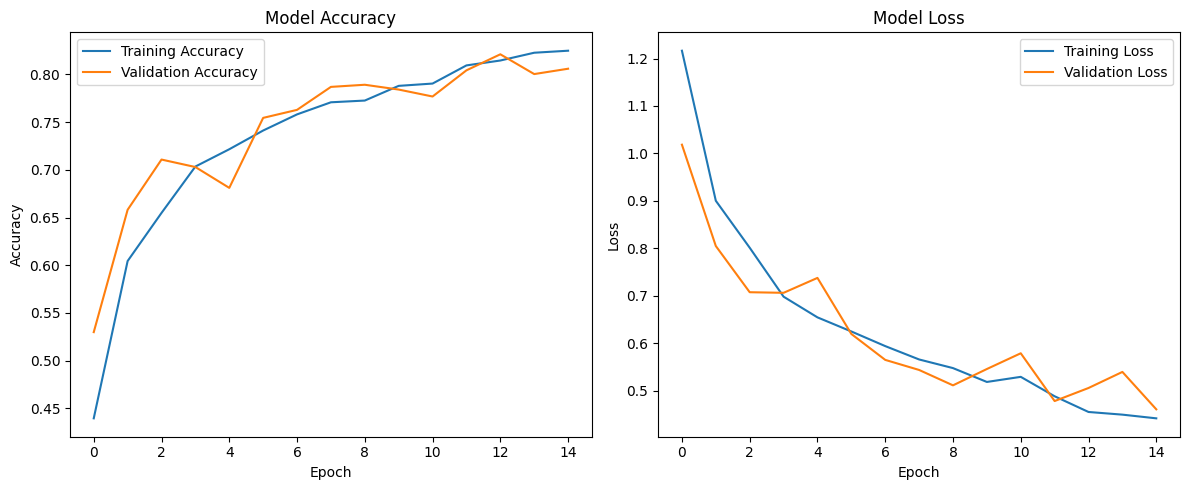

In [8]:
import matplotlib.pyplot as plt

# === Visualization of training ===
print("Visualizing training results...")

# Plot accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() #Adds necessary labeling to plot

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

def predict_new_image(img_path):
    model = load_model(model_path)

    # Load image in color (RGB)
    img = Image.open(img_path).convert("RGB")
    img = img.resize((150, 150))

    img_array = np.array(img).astype("float32") / 255.0
    img_array = img_array.reshape(1, 150, 150, 3)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0][predicted_index]

    # Display
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {classes[predicted_index]}, Confidence: ({confidence:.2%})")#Prints name of classes most likely to be the flower species alongside the prediction confidence level
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


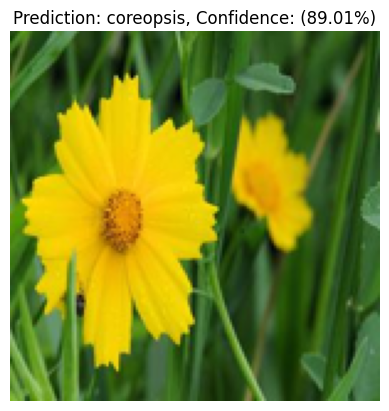

In [33]:
predict_new_image("/content/flower_species_dataset/testing/coreopsis/4842712100_ce1cbc5646_c.jpg")